---

## CoAVAREP Features

CoAVAREP is designed to extract features from audio signals, focusing on the acoustic aspects of speech.

### Modality
- **Type:** Audio
- **Purpose:**
  - Captures acoustic and paralinguistic characteristics (e.g., pitch, prosody, voice quality, spectral properties)

### Feature Extraction
- **Method:** Utilizes signal processing algorithms
- **Dimensionality:** Determined by the number of computed acoustic features (varies based on configuration)
- **Applications:**
  - Emotion Recognition
  - Speaker Identification
  - Voice Quality Assessment

---



### Importing Libraries

In [31]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import (
	Conv2D,
	MaxPooling2D,
	AveragePooling2D,
	Flatten,
	Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Loading Data Tensors

In [2]:
with open('../data/tensors.pkl', 'rb') as fr:
    data_tensors = pickle.load(fr)

### Prepare Data into Partitions that make sense

In [3]:
partitions_ = data_tensors[1]
data_all = data_tensors[0]
data_partitions = {partitions_[0]: data_all[0], partitions_[1]: data_all[1], partitions_[2]: data_all[2]}


In [4]:
data_partitions['train'].keys()

dict_keys(['COAVAREP', 'FACET 4.2', 'OpenFace_2.0', 'All Labels', 'glove_vectors', 'OpenSMILE'])

In [6]:
data_partitions['train']['COAVAREP'].shape

(16327, 50, 74)

### Exploring Training Data Distribution

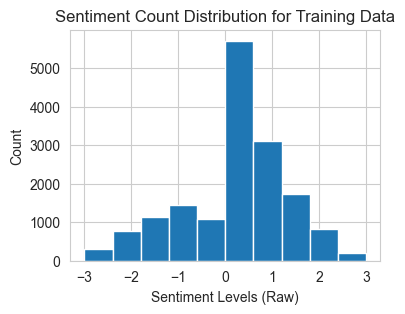

In [52]:
# looking at sentiment probability distribution in train
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(data_partitions['train']['All Labels'][:, :, 0])
ax.set_xlabel("Sentiment Levels (Raw)")
ax.set_ylabel("Count")
ax.set_title('Sentiment Count Distribution for Training Data')
plt.show()

### Extract COAVAREP Only

In [14]:
for k in data_partitions['train'].keys():
    if k == 'COAVAREP':
        X_train = data_partitions['train'][k]
        X_test = data_partitions['test'][k]
        X_val = data_partitions['valid'][k]
        print(f'{k} has dimension {X_train.shape[1:]}')

COAVAREP has dimension (50, 74)


### Preparing Labels for Training, Testing, and Validation

In [15]:
emo_selected = 0 # sentiment
Y_train = data_partitions['train']['All Labels'][:, :, emo_selected]
Y_test = data_partitions['test']['All Labels'][:, :, emo_selected]
Y_val = data_partitions['valid']['All Labels'][:, :, emo_selected]

# Round the values to the nearest integer
Y_train_rounded = np.round(Y_train).astype(int)
Y_test_rounded = np.round(Y_test).astype(int)
Y_val_rounded = np.round(Y_val).astype(int)

# If you need class indices from 0 to 6 instead of -3 to 3, you can shift them:
Y_train_classes = Y_train_rounded + 3
Y_test_classes = Y_test_rounded + 3
Y_val_classes = Y_val_rounded + 3

print(Y_train_classes.shape, Y_test_classes.shape, Y_val_classes.shape)

(16327, 1) (4662, 1) (1871, 1)


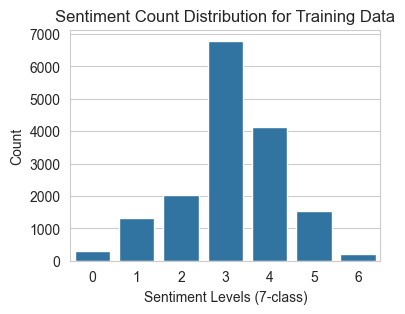

In [65]:
# If Y_train_classes is multidimensional, flatten it to 1D
y_train_flat = Y_train_classes.flatten()

# Create the countplot
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x=y_train_flat, ax=ax)
ax.set_xlabel("Sentiment Levels (7-class)")
ax.set_ylabel("Count")
ax.set_title('Sentiment Count Distribution for Training Data')
plt.show()

### Building the CNN Model

In [18]:
input_dim_1 = X_train.shape[1]
input_dim_2 = X_train.shape[2]
# since classes are: -3, -2, -1, 0, 1, 2, 3 (or 0-6 after shifting)
num_classes = 7

model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (5, 5), activation="relu",
                 input_shape=(input_dim_1, input_dim_2, 1)))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

# 2nd convolution layer
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())

# Classification output layer: 7 neurons with softmax activation
model.add(Dense(num_classes, activation="softmax"))
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/Users/alexanderhsu/Documents/GitHub/11777-EMOji/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Preparing Data for Model Training

In [19]:
X_train_reshape = X_train.reshape(-1, input_dim_1, input_dim_2, 1)
Y_train_reshape = np.array(Y_train_classes).reshape(-1, 1)
X_test_reshape = X_test.reshape(-1, input_dim_1, input_dim_2, 1)
Y_test_reshape = np.array(Y_test_classes).reshape(-1, 1)
X_val_reshape = X_val.reshape(-1, input_dim_1, input_dim_2, 1)
Y_val_reshape = np.array(Y_val_classes).reshape(-1, 1)

# there could be some inf values in features
# Replace Inf values with the max finite value in X_data
X_train_reshape[np.isinf(X_train_reshape)] = np.nan 
X_train_reshape = np.nan_to_num(X_train_reshape, nan=np.nanmax(X_train_reshape)) 
# Replace Inf values with the max finite value in X_data
X_test_reshape[np.isinf(X_test_reshape)] = np.nan 
X_test_reshape = np.nan_to_num(X_test_reshape, nan=np.nanmax(X_test_reshape)) 
# Replace Inf values with the max finite value in X_data
X_val_reshape[np.isinf(X_val_reshape)] = np.nan 
X_val_reshape = np.nan_to_num(X_val_reshape, nan=np.nanmax(X_val_reshape))

### Training the Model

In [21]:
history = model.fit(X_train_reshape, 
                    Y_train_reshape, 
                    epochs=200,       # Adjust as needed
                    batch_size=32,   # Adjust based on available memory
                    validation_data=(X_val_reshape, Y_val_reshape),
                    verbose=2)


Epoch 1/200
511/511 - 17s - 34ms/step - accuracy: 0.4072 - loss: 1.5471 - val_accuracy: 0.4441 - val_loss: 1.4614
Epoch 2/200
511/511 - 17s - 33ms/step - accuracy: 0.4128 - loss: 1.5210 - val_accuracy: 0.4447 - val_loss: 1.4616
Epoch 3/200
511/511 - 17s - 33ms/step - accuracy: 0.4161 - loss: 1.5105 - val_accuracy: 0.4404 - val_loss: 1.4526
Epoch 4/200
511/511 - 17s - 33ms/step - accuracy: 0.4168 - loss: 1.5018 - val_accuracy: 0.4425 - val_loss: 1.4514
Epoch 5/200
511/511 - 17s - 33ms/step - accuracy: 0.4169 - loss: 1.4953 - val_accuracy: 0.4356 - val_loss: 1.4606
Epoch 6/200
511/511 - 17s - 33ms/step - accuracy: 0.4197 - loss: 1.4885 - val_accuracy: 0.4415 - val_loss: 1.4511
Epoch 7/200
511/511 - 17s - 34ms/step - accuracy: 0.4196 - loss: 1.4817 - val_accuracy: 0.4431 - val_loss: 1.4622
Epoch 8/200
511/511 - 17s - 34ms/step - accuracy: 0.4187 - loss: 1.4748 - val_accuracy: 0.4447 - val_loss: 1.4724
Epoch 9/200
511/511 - 17s - 34ms/step - accuracy: 0.4213 - loss: 1.4701 - val_accuracy: 

In [64]:
# Save the entire model (architecture, weights, and optimizer state)
model.save("../models/coavarep_unimodal_baseline_model.h5")

### Evaluating Model - Predictions and Metrics

In [54]:
y_predict = np.argmax(model.predict(X_test_reshape), axis=1)

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [59]:
# Compute the confusion matrix
cm = confusion_matrix(Y_test_reshape, y_predict, normalize='true')

# Compute precision, recall, and f1-score using classification_report
report = classification_report(Y_test_reshape, y_predict)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.15      0.12      0.13       399
           2       0.12      0.14      0.13       554
           3       0.42      0.49      0.45      1927
           4       0.28      0.28      0.28      1230
           5       0.11      0.06      0.07       441
           6       0.00      0.00      0.00        41

    accuracy                           0.31      4662
   macro avg       0.16      0.15      0.15      4662
weighted avg       0.29      0.31      0.30      4662



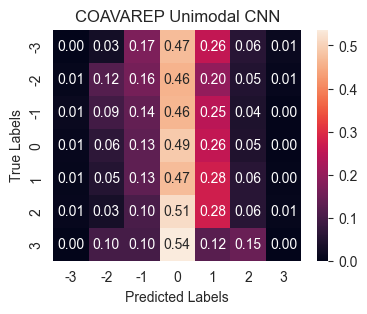

In [68]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=np.arange(-3, 3.1).astype(int),
			yticklabels=np.arange(-3, 3.1).astype(int), ax=ax)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("COAVAREP Unimodal CNN")
plt.show()
fig.savefig('../figures/coavarep_unimodal_baseline_confusion_matrix.png', bbox_inches='tight', dpi=300)